# Solución al Caso Práctico de Visión Artificial: Detección de Deforestación

Este cuaderno contiene la implementación paso a paso para la detección y cuantificación de áreas deforestadas en imágenes satelitales del Bosque Nacional Jamanxim.

## 1. Configuración e Importación de Librerías

In [48]:
import os
import cv2
import glob
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

In [49]:
# Constantes de escala
PIXELS_REF = 51
KM_REF = 20
AREA_PER_PIXEL = (KM_REF / PIXELS_REF) ** 2
print(f"Área por píxel: {AREA_PER_PIXEL:.4f} km²")

Área por píxel: 0.1538 km²


## 2. Carga y Exploración de Datos

Definimos la ruta de las imágenes extraídas y cargamos la secuencia temporal.

Se encontraron 20 imágenes.


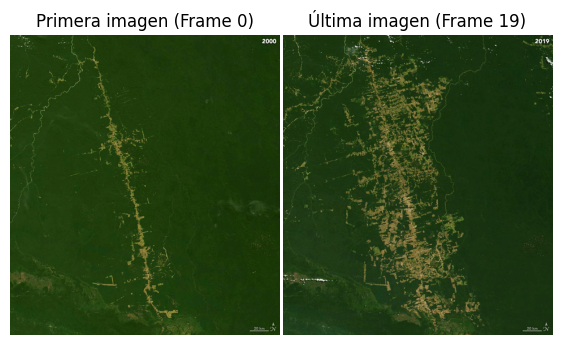

In [50]:
input_dir = r"extracted_frames"
image_files = sorted(glob.glob(os.path.join(input_dir, "*.png")))

print(f"Se encontraron {len(image_files)} imágenes.")

if image_files:
    # Leer primera imagen
    img_first = cv2.imread(image_files[0])
    img_first_rgb = cv2.cvtColor(img_first, cv2.COLOR_BGR2RGB)

    # Leer última imagen
    img_last = cv2.imread(image_files[-1])
    img_last_rgb = cv2.cvtColor(img_last, cv2.COLOR_BGR2RGB)

    # Crear subplots
    plt.figure(figsize=(7, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img_first_rgb)
    plt.title("Primera imagen (Frame 0)")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(img_last_rgb)
    plt.title(f"Última imagen (Frame {len(image_files)-1})")
    plt.axis("off")

    plt.subplots_adjust(wspace=0.01)
    plt.savefig("out/evolucion_frames.png", dpi=300)

    plt.show()

In [51]:
def select_random_seeds(image, margin_percent, dark_mask, num_seeds=10, seed=None):

    h, w = image.shape[:2]

    # Márgenes
    margin_y = int(margin_percent * h)
    margin_x = int(margin_percent * w)

    y_min, y_max = margin_y, h - margin_y
    x_min, x_max = margin_x, w - margin_x

    # Región central (a excluir)
    central_mask = np.zeros(dark_mask.shape, dtype=bool)
    central_mask[y_min:y_max, x_min:x_max] = True

    # Oscuros fuera del margen central
    valid_mask = dark_mask & ~central_mask

    # División izquierda / derecha
    mid_x = w // 2

    left_mask  = valid_mask & (np.arange(w)[None, :] < mid_x)
    right_mask = valid_mask & (np.arange(w)[None, :] >= mid_x)

    ys_l, xs_l = np.where(left_mask)
    ys_r, xs_r = np.where(right_mask)

    if len(xs_l) == 0 and len(xs_r) == 0:
        return []

    np.random.seed(seed)

    n_left  = num_seeds // 2
    n_right = num_seeds - n_left

    seeds = []

    if len(xs_l) > 0:
        idx_l = np.random.choice(len(xs_l),
                                 size=min(n_left, len(xs_l)),
                                 replace=False)
        seeds.extend(zip(ys_l[idx_l], xs_l[idx_l]))

    if len(xs_r) > 0:
        idx_r = np.random.choice(len(xs_r),
                                 size=min(n_right, len(xs_r)),
                                 replace=False)
        seeds.extend(zip(ys_r[idx_r], xs_r[idx_r]))

    return seeds


In [52]:
def plot_intensity_analysis(image, title_prefix, margin_percent=0.2, percentile_bright=98, percentile_dark=30, num_seeds= 10, seed=42):
    """Grafica: Original | Grises | Histograma Intensidad | Máscara Brillo (>percentile_bright99)."""

    h, w = image.shape[:2]

    margin_y = int(margin_percent * h)
    margin_x = int(margin_percent * w)

    y_min, y_max = margin_y, h - margin_y
    x_min, x_max = margin_x, w - margin_x

    img_vis = image.copy()
    img_vis = cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    threshold = np.percentile(gray, percentile_bright)
    bright_mask = gray >= threshold

    threshold2 = np.percentile(gray, percentile_dark)
    dark_mask = gray <= threshold2
    # kernel = np.ones((3,3), np.uint8)
    # bright_mask_clean = cv2.morphologyEx(bright_mask.astype(np.uint8),
    #                                      cv2.MORPH_OPEN,
    #                                      kernel)
    print(
    f"Alto {h} por ancho {w} de la imagen = {h * w} pixeles\n",    
    f"p{percentile_bright} = {threshold:.1f}\n",
    f"Area de pixeles brillosos: {np.count_nonzero(bright_mask) * AREA_PER_PIXEL :.3f} Km2"
    )

    plt.figure(figsize=(20, 5))
    
    # 1. Imagen Original (Convertir BGR a RGB para matplotlib)
    plt.subplot(1, 5, 1)
    plt.imshow(img_vis)
    plt.title(f"{title_prefix} - Original")
    plt.axis('off')
    
    # 2. Escala de Grises
    plt.subplot(1, 5, 2)
    plt.imshow(gray, cmap='gray')
    plt.title("Escala de Grises")
    plt.axis('off')

    # 3. Histograma de Intensidades
    plt.subplot(1, 5, 3)
    plt.hist(gray.ravel(), bins=256, color='gray')
    plt.axvline(threshold, color='r', linestyle='--', label=f'p{percentile_bright}: {threshold:.1f}')
    plt.title("Histograma de Intensidad")
    plt.xlabel("Intensidad")
    plt.ylabel("Frecuencia")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. Máscara de Alta Intensidad
    plt.subplot(1, 5, 4)
    plt.imshow(bright_mask, cmap='gray')
    plt.title("Máscara de Alta Intensidad")
    plt.axis('off')

    # 5. Seleccion aleatoria de semillas
    seeds = select_random_seeds(gray, margin_percent, dark_mask, num_seeds, seed)
    # Dibujar ROI Region central
    cv2.rectangle(img_vis,
                (x_min, y_min),
                (x_max, y_max),
                (255, 255, 0), 2)

    # Dibujar semillas
    for y, x in seeds:
        cv2.circle(img_vis, (x, y), 3, (255, 0, 0), -1)
    
    plt.subplot(1, 5, 5)
    plt.imshow(img_vis, cmap='gray')
    plt.title(f"Selección Aleatoria de {num_seeds} semillas")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

Alto 800 por ancho 720 de la imagen = 576000 pixeles
 p98.1 = 90.0
 Area de pixeles brillosos: 1710.573 Km2


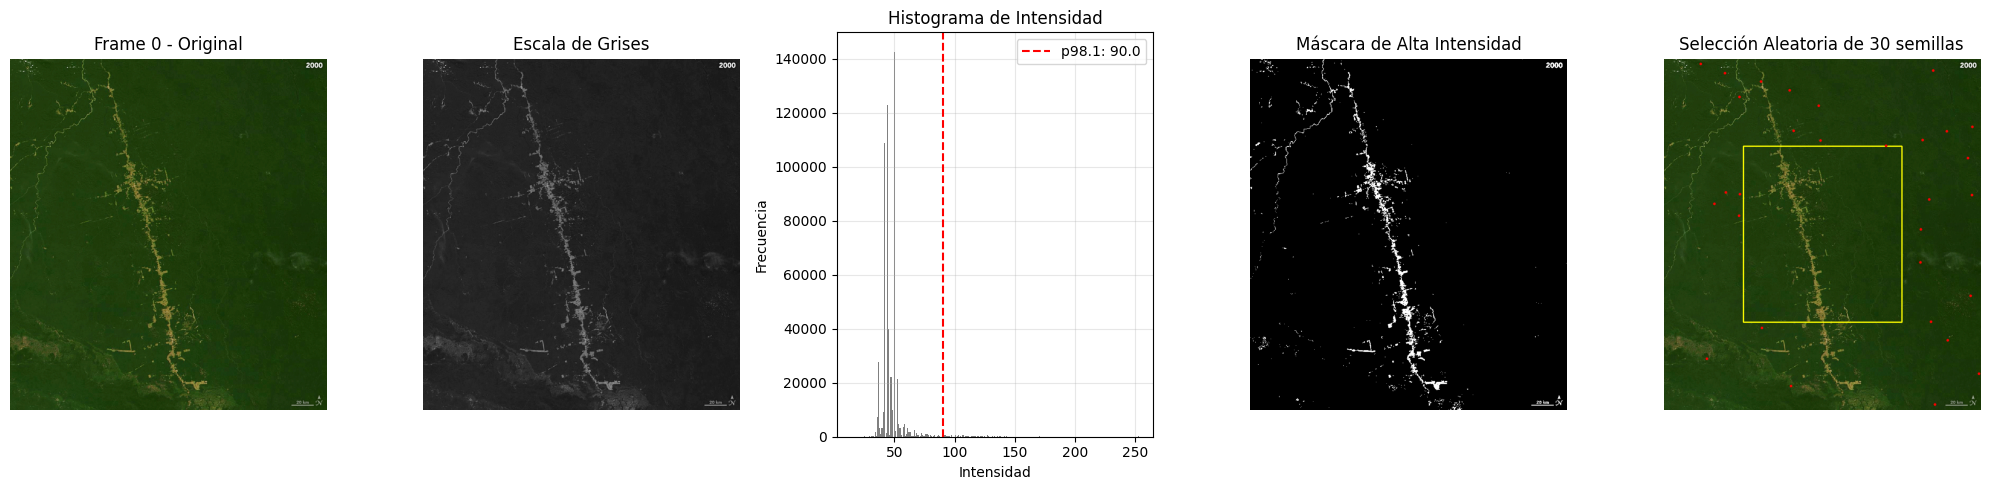

Alto 800 por ancho 720 de la imagen = 576000 pixeles
 p91 = 81.0
 Area de pixeles brillosos: 8026.759 Km2


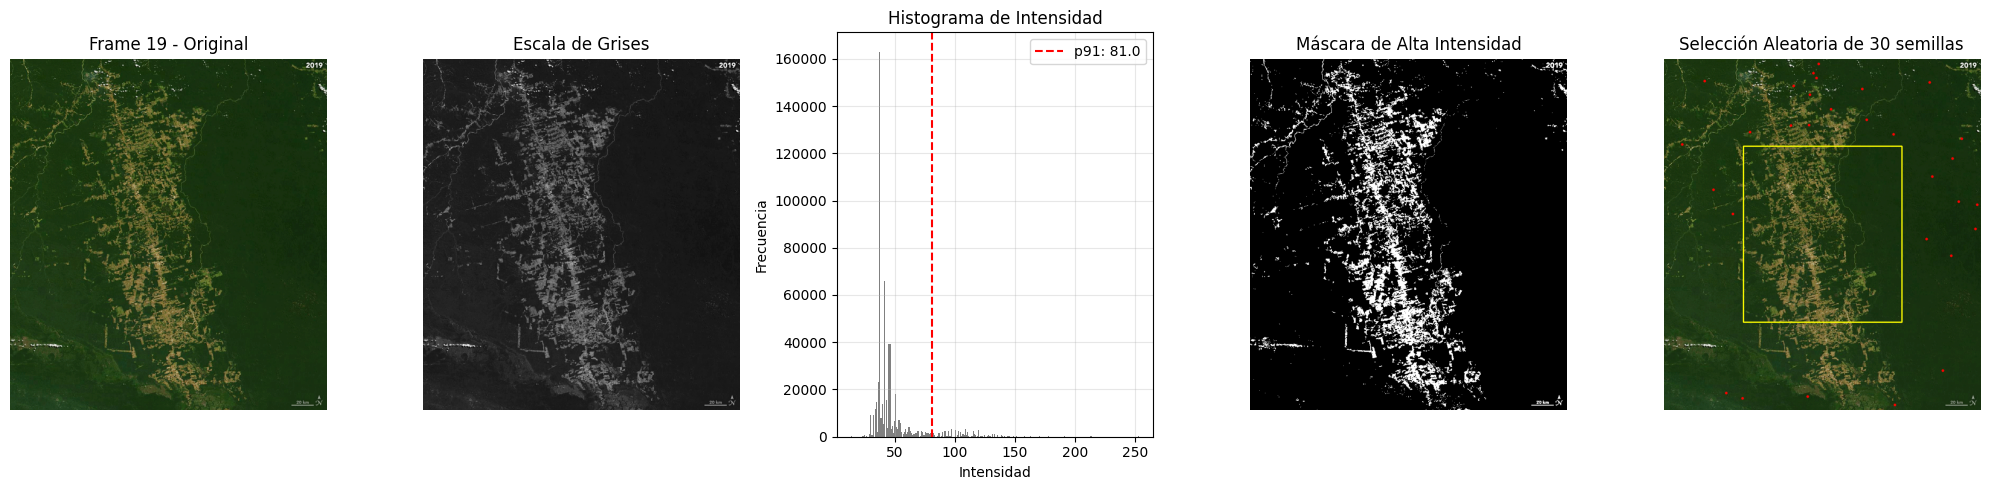

In [53]:
# Índices de los frames a analizar
frame_indices = [0, 19]

for idx in frame_indices:
    if idx < len(image_files):
        img_path = image_files[idx]
        img = cv2.imread(img_path)
        
        if img is not None:
            if idx == 0:
                plot_intensity_analysis(image=img, title_prefix=f"Frame {idx}", margin_percent=0.25,
                                        percentile_bright=98.1, num_seeds=30, seed=30)
            else:
                plot_intensity_analysis(image=img, title_prefix=f"Frame {idx}", margin_percent=0.25,
                                        percentile_bright=91, num_seeds=30, seed=30)
        else:
            print(f"Error al cargar frame {idx}")

## 3. Implementación de Algoritmos de Segmentación

Se implementan funciones para:
1.  **Preprocesamiento**: Mejora de contraste (CLAHE).
2.  **Segmentación por Umbral (Otsu)**.
3.  **Segmentación por Color (HSV/Lab)**.
4.  **Post-procesamiento**: Operaciones morfológicas.

In [54]:
def preprocess_image(image):
    """
    Aplica conversión a escala de grises y mejora de contraste (CLAHE).
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)
    # Suavizado para reducir ruido
    blurred = cv2.GaussianBlur(enhanced, (5, 5), 0)
    return blurred

def segment_otsu(image):
    """
    Segmentación basada en umbralización de Otsu.
    """
    processed = preprocess_image(image)
    # Otsu invierte si el objeto es oscuro sobre fondo claro, ajustamos según necesidad
    # Asumimos que la deforestación (tierra) es más clara o distinta del bosque oscuro
    ret, mask = cv2.threshold(processed, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return mask

def vegetation_mask_exg(img):

    b, g, r = cv2.split(img.astype(np.float32))
    exg = 2*g - r - b
    exg_norm = cv2.normalize(exg, None, 0, 255, cv2.NORM_MINMAX)
    
    return exg_norm > 120  # vegetación

def segment_color_hsv(image):
    """
    Segmentación basada en color HSV para aislar zonas no verdes (tierra/deforestado).
    """
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    lower_soil = np.array([5, 30, 40])
    upper_soil = np.array([35, 200, 220])

    mask_soil = cv2.inRange(hsv, lower_soil, upper_soil)

    veg = vegetation_mask_exg(img)

    # suelo urbano = suelo HSV pero NO vegetación
    mask_urban = mask_soil & (~veg.astype(np.uint8)*255)

    return mask_urban

def post_process_morphology(mask):
    """
    Aplica operaciones morfológicas para limpiar la máscara.
    """
    kernel = np.ones((5,5), np.uint8)
    # Opening para quitar ruido blanco (pequeños puntos)
    opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    # Closing para cerrar agujeros dentro de las zonas detectadas
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    return closing

In [55]:
def segment_region_growing_forest(
    img,
    percentile=25,
    num_seeds=50,
    tolerance=18,
    margin_percent=0.25,
    seed=30
):

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rows, cols = gray.shape

    # 1️⃣ Máscara de oscuros
    threshold = np.percentile(gray, percentile)
    dark_mask = gray <= threshold

    # 2️⃣ Semillas estratificadas
    seeds = select_random_seeds(
        gray,
        margin_percent,
        dark_mask,
        num_seeds,
        seed
    )

    if len(seeds) == 0:
        return np.zeros_like(gray, dtype=np.uint8)

    segmentation = np.zeros_like(gray, dtype=np.uint8)
    processed = np.zeros_like(gray, dtype=bool)

    # 3️⃣ Region growing por seed (NO global)
    for sy, sx in seeds:

        if processed[sy, sx]:
            continue

        queue = deque([(sy, sx)])
        region_mean = float(gray[sy, sx])

        processed[sy, sx] = True
        segmentation[sy, sx] = 255

        while queue:
            y, x = queue.popleft()

            for dy, dx in [(-1,0),(1,0),(0,-1),(0,1)]:
                ny, nx = y + dy, x + dx

                if 0 <= ny < rows and 0 <= nx < cols and not processed[ny, nx]:
                    diff = abs(float(gray[ny, nx]) - region_mean)

                    if diff < tolerance:
                        processed[ny, nx] = True
                        segmentation[ny, nx] = 255
                        queue.append((ny, nx))

                        # actualización lenta del promedio
                        region_mean = 0.99 * region_mean + 0.01 * gray[ny, nx]

    # overlay = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

    # for y, x in seeds:
    #     cv2.circle(overlay, (x, y), 3, (0,0,255), -1)

    # overlay[segmentation == 255] = [0,255,0]

    # plt.imshow(overlay)
    # plt.title("Seeds (rojo) + Región Crecida (verde)")
    # plt.axis("off")
    # plt.show()

    return segmentation

In [56]:
def segment_split_merge_approx(img):
    # Mean Shift como aproximación
    return cv2.pyrMeanShiftFiltering(img, 20, 40, 1)

def segment_kmeans(img, k=4):
    pixel_values = img.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # Heurística: Identificar clusters que NO son verdes (deforestación)
    # Convertir centros a HSV para comprobar verde
    centers_hsv = cv2.cvtColor(np.uint8([centers]), cv2.COLOR_BGR2HSV)[0]
    
    # Rango verde (mismo que segment_color_hsv)
    lower_green = np.array([35, 40, 40])
    upper_green = np.array([85, 255, 255])
    
    deforested_labels = []
    for i, center_hsv in enumerate(centers_hsv):
        # Si NO está en el rango verde, es deforestado
        if not (np.all(center_hsv >= lower_green) and np.all(center_hsv <= upper_green)):
            deforested_labels.append(i)
            
    # Crear máscara
    mask = np.isin(labels.flatten(), deforested_labels).reshape(img.shape[:2])
    return (mask.astype(np.uint8) * 255)

def segment_slic(img, n_segments=200):
    try:
        from skimage.segmentation import slic
        from skimage.util import img_as_float
        
        # SLIC
        segments = slic(img_as_float(img), n_segments=n_segments, compactness=10, sigma=1, start_label=0)
        
        # Clasificar segmentos como deforestación si su color medio no es verde
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        
        # Convertir imagen a HSV para análisis de color
        hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        lower_green = np.array([35, 40, 40])
        upper_green = np.array([85, 255, 255])
        
        for seg_idx in np.unique(segments):
            # Máscara del segmento actual
            seg_mask = (segments == seg_idx)
            
            # Color medio en HSV
            mean_color = cv2.mean(hsv_img, mask=seg_mask.astype(np.uint8))[:3]
            
            # Chequear si es verde
            is_green = (lower_green[0] <= mean_color[0] <= upper_green[0]) and (lower_green[1] <= mean_color[1] <= upper_green[1]) and (lower_green[2] <= mean_color[2] <= upper_green[2])
            
            if not is_green:
                mask[seg_mask] = 255
                
        return mask
    except ImportError:
        return np.zeros(img.shape[:2], dtype=np.uint8)

In [57]:
# GrabCut
def segment_grabcut_forest(img, iterations=5):
    '''
    1. Inicialización por máscara adaptativa
    2. Usar intensidad para preclasificar (Oscuro=Bosque, Claro=Deforestación)
    3. Segmentar bosque como foreground
    4. Invertir para obtener deforestación
    5. Suavizar con morfología
    '''
    h, w = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 1️⃣ Inicialización: Todo es Probable Foreground (Bosque)
    # Asumimos que la mayor parte es bosque
    grabcut_mask = np.full((h, w), cv2.GC_PR_FGD, np.uint8)

    # 2️⃣ Preclasificación por Intensidad
    # Suelo/Deforestación suele ser más claro que el bosque denso
    
    # Zona clara -> Fondo Seguro (Deforestación)
    p_bright = np.percentile(gray, 95) 
    grabcut_mask[gray > p_bright] = cv2.GC_BGD
    
    # Zona oscura -> Bosque Seguro
    p_dark = np.percentile(gray, 30)
    grabcut_mask[gray < p_dark] = cv2.GC_FGD

    # Nota: Eliminamos la inicialización de bordes fijos ya que puede inducir errores
    # si el bosque toca los bordes.

    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    try:
        cv2.grabCut(
            img,
            grabcut_mask,
            None,
            bgdModel,
            fgdModel,
            iterations,
            cv2.GC_INIT_WITH_MASK
        )
    except cv2.error:
        # Fallback si GrabCut falla
        return np.zeros((h,w), dtype=np.uint8)

    # 3️⃣ Extraer Bosque (FGD + PR_FGD)
    forest = np.where(
        (grabcut_mask == cv2.GC_FGD) | (grabcut_mask == cv2.GC_PR_FGD),
        255, 0
    ).astype(np.uint8)
    
    # 4️⃣ Suavizado con Morfología
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    forest = cv2.morphologyEx(forest, cv2.MORPH_OPEN, kernel)
    forest = cv2.morphologyEx(forest, cv2.MORPH_CLOSE, kernel)

    # 5️⃣ Invertir para retornar Deforestación
    return cv2.bitwise_not(forest)

In [58]:
def segment_watershed(
    img,
    percentile_dark=30,
    margin_percent=0.25,
    num_seeds=80,
    tolerance=30
):
    
    # Segmentación por Watershed mejorada usando Otsu para binarización robusta.
    # Retorna máscara de deforestación (255 = deforestado).
    
    # --- 1. Preprocesamiento ---
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img
        
    h, w = gray.shape
    gray_blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # --- 2. Máscaras globales (Otsu) ---
    # Usamos Otsu para encontrar el umbral óptimo automáticamentte
    ret, thresh_otsu = cv2.threshold(gray_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Definimos zonas seguras
    # Usamos un margen fijo o dinámico para asegurar pureza de las semillas
    margin_val = 5
    
    # Bosque: Zonas definitivamente oscuras
    dark_mask = gray_blur < (ret - margin_val)
    
    # Fondo/Deforestado: Zonas definitivamente claras
    bright_mask = gray_blur > (ret + margin_val)

    # --- 3. Selección de semillas oscuras ---
    seeds = select_random_seeds(
        gray_blur,
        margin_percent,
        dark_mask, # Usamos la máscara de Otsu
        num_seeds=num_seeds,
        seed=42
    )

    if len(seeds) == 0:
        return np.zeros_like(gray, dtype=np.uint8)

    # --- 4. Máscara de semillas ---
    seed_mask = np.zeros((h, w), dtype=np.uint8)
    for y, x in seeds:
        seed_mask[y, x] = 255

    seed_mask = cv2.dilate(seed_mask, np.ones((3,3), np.uint8), iterations=1)

    # --- 5. Marcadores Watershed ---
    markers = np.zeros((h, w), dtype=np.int32)
    # Marcador 1: Bosque (Semillas)
    markers[seed_mask > 0] = 1
    # Marcador 2: Fondo (Bright Area)
    markers[bright_mask] = 2   
    
    # --- 6. Gradiente ---
    gradient = cv2.Laplacian(gray_blur, cv2.CV_32F)
    gradient = np.abs(gradient)
    gradient = cv2.normalize(gradient, None, 0, 255, cv2.NORM_MINMAX)
    gradient = gradient.astype(np.uint8)
    gradient_color = cv2.cvtColor(gradient, cv2.COLOR_GRAY2BGR)

    # --- 7. Watershed ---
    cv2.watershed(gradient_color, markers)

    # --- 8. EXTRAER BOSQUE ---
    forest = np.zeros((h, w), dtype=np.uint8)
    forest[markers == 1] = 255
    
    # Limpieza: Asegurar que el bosque no incluya zonas muy brillantes (falsos positivos)
    forest[gray_blur > (ret + margin_val*4)] = 0

    # --- Limpieza morfológica ---
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    forest = cv2.morphologyEx(forest, cv2.MORPH_OPEN, kernel)
    forest = cv2.morphologyEx(forest, cv2.MORPH_CLOSE, kernel)

    # --- 9. Deforestación (Inverso del bosque) ---
    deforestation = cv2.bitwise_not(forest)

    # #--- Debug visual ---
    # overlay = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    # for y, x in seeds:
    #     cv2.circle(overlay, (x, y), 3, (0,0,255), -1)
    # overlay[deforestation == 255] = [0,255,0]
    # plt.figure(figsize=(5,5))
    # plt.imshow(overlay)
    # plt.axis("off")
    # plt.show()

    return deforestation


In [59]:
# Inicializar Motion Subtractor
# history=200: aprende rápido cambios de iluminación entre años
# varThreshold=50: umbral alto para reducir ruido
# detectShadows=False: no contar sombras como deforestación
backSub = cv2.createBackgroundSubtractorMOG2(history=200, varThreshold=50, detectShadows=False)
# Kernel para limpieza de ruido
kernel_clean = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

## 4. Segmentacion y calculo de area deforestada

Calculamos el área deforestada usando la escala proporcionada:
- **51 píxeles = 20 km**
- Factor de escala lineal: $20 / 51$ km/px
- Factor de área: $(20 / 51)^2$ km²/px²

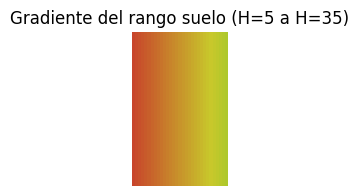

In [60]:
lower_soil = np.array([5, 30, 40])
upper_soil = np.array([35, 200, 220])

h_values = np.arange(lower_soil[0], upper_soil[0] + 1)
s = 200  # saturación fija
v = 200  # brillo fijo

hsv_strip = np.zeros((50, len(h_values), 3), dtype=np.uint8)

for i, h in enumerate(h_values):
    hsv_strip[:, i] = [h, s, v]

rgb_strip = cv2.cvtColor(hsv_strip, cv2.COLOR_HSV2RGB)

plt.figure(figsize=(10, 2))
plt.imshow(rgb_strip)
plt.title("Gradiente del rango suelo (H=5 a H=35)")
plt.axis("off")
plt.show()

In [63]:
# Crear carpeta out si no existe
os.makedirs('out', exist_ok=True)

results = {
    'Otsu':[],
    'Color (HSV)':[],
    'Region Growing':[],
    'K-Means':[],
    'SLIC':[],
    'GrabCut':[],
    'Watershed':[],
    'Motion (MOG2)':[]
}

years = list(range(2000, 2000 + len(image_files))) 

In [64]:
print("Procesando imágenes...")

# Crear carpeta out si no existe
os.makedirs('out', exist_ok=True)

for idx, img_path in enumerate(image_files):
    img = cv2.imread(img_path)
    if img is None: continue
    
    current_masks = {}
    
    # --- Métodos ---
    # Otsu
    try:
        mask_otsu = segment_otsu(img)
        mask_otsu_clean = post_process_morphology(mask_otsu)
        results['Otsu'].append(cv2.countNonZero(mask_otsu_clean) * AREA_PER_PIXEL)
        current_masks['Otsu'] = mask_otsu_clean
    except: results['Otsu'].append(0)
    
    # Color
    try:
        mask_color = segment_color_hsv(img)
        results['Color (HSV)'].append(cv2.countNonZero(mask_color) * AREA_PER_PIXEL)
        current_masks['Color (HSV)'] = mask_color
    except: results['Color (HSV)'].append(0)
    
    # Region Growing
    try:
        forest_mask = segment_region_growing_forest(
            img,
            percentile = np.clip(30 + idx * 0.4, 30, 40),
            num_seeds=30,
            tolerance=32,
            seed=30
        )
        deforestation_mask = cv2.bitwise_not(forest_mask)
        area = cv2.countNonZero(deforestation_mask) * AREA_PER_PIXEL
        results['Region Growing'].append(area)
        current_masks['Region Growing'] = deforestation_mask
    except: results['Region Growing'].append(0)
        
    # K-Means
    try:
        mask_kmeans = segment_kmeans(img)
        results['K-Means'].append(cv2.countNonZero(mask_kmeans) * AREA_PER_PIXEL)
        current_masks['K-Means'] = mask_kmeans
    except: results['K-Means'].append(0)
        
    # SLIC
    try:
        mask_slic = segment_slic(img)
        results['SLIC'].append(cv2.countNonZero(mask_slic) * AREA_PER_PIXEL)
        current_masks['SLIC'] = mask_slic
    except: results['SLIC'].append(0)
        
    # GrabCut
    try:
        mask_grab = segment_grabcut_forest(
            img,
            iterations=5
        )
        results['GrabCut'].append(cv2.countNonZero(mask_grab) * AREA_PER_PIXEL)
        current_masks['GrabCut'] = mask_grab
    except: results['GrabCut'].append(0)
        
    # Watershed
    try:
        mask_ws = segment_watershed(
            img,
            percentile_dark = np.clip(30 + idx * 0.4, 30, 40),
            margin_percent=0.25,
            num_seeds=500,
            tolerance=30
        )
        results['Watershed'].append(cv2.countNonZero(mask_ws) * AREA_PER_PIXEL)
        current_masks['Watershed'] = mask_ws
    except: results['Watershed'].append(0)
        
    # Motion
    # Aplicar sustracción de fondo
    try:
        fg_mask = backSub.apply(img)

        # Frame 0 siempre da alto por inicialización, lo forzamos a 0
        if idx == 0:
            results['Motion (MOG2)'].append(0)
            # Limpieza morfológica para eliminar ruido (puntos sueltos)
            fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, kernel_clean)
            current_masks['Motion (MOG2)'] = fg_mask
        else:
            # Limpieza morfológica para eliminar ruido (puntos sueltos)
            fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, kernel_clean)

            # Calcular área
            area = cv2.countNonZero(fg_mask) * AREA_PER_PIXEL
            results['Motion (MOG2)'].append(area)
            current_masks['Motion (MOG2)'] = fg_mask
    except: results['Motion (MOG2)'].append(0)

    # --- Guardado de mascaras (Frame 0 y Ultimo Frame) ---
    if idx == 0 or idx == len(image_files) - 1:
        for method, mask in current_masks.items():
            filename = f"out/mask_{method.replace(' ', '_').replace('(', '').replace(')', '')}_{idx}.png"
            cv2.imwrite(filename, mask)
        print(f"Máscaras guardadas")

    print(f"Procesado año {years[idx]}")

print("Procesamiento completado.")


Procesando imágenes...
Máscaras guardadas
Procesado año 2000
Procesado año 2001
Procesado año 2002
Procesado año 2003
Procesado año 2004
Procesado año 2005
Procesado año 2006
Procesado año 2007
Procesado año 2008
Procesado año 2009
Procesado año 2010
Procesado año 2011
Procesado año 2012
Procesado año 2013
Procesado año 2014
Procesado año 2015
Procesado año 2016
Procesado año 2017
Procesado año 2018
Máscaras guardadas
Procesado año 2019
Procesamiento completado.


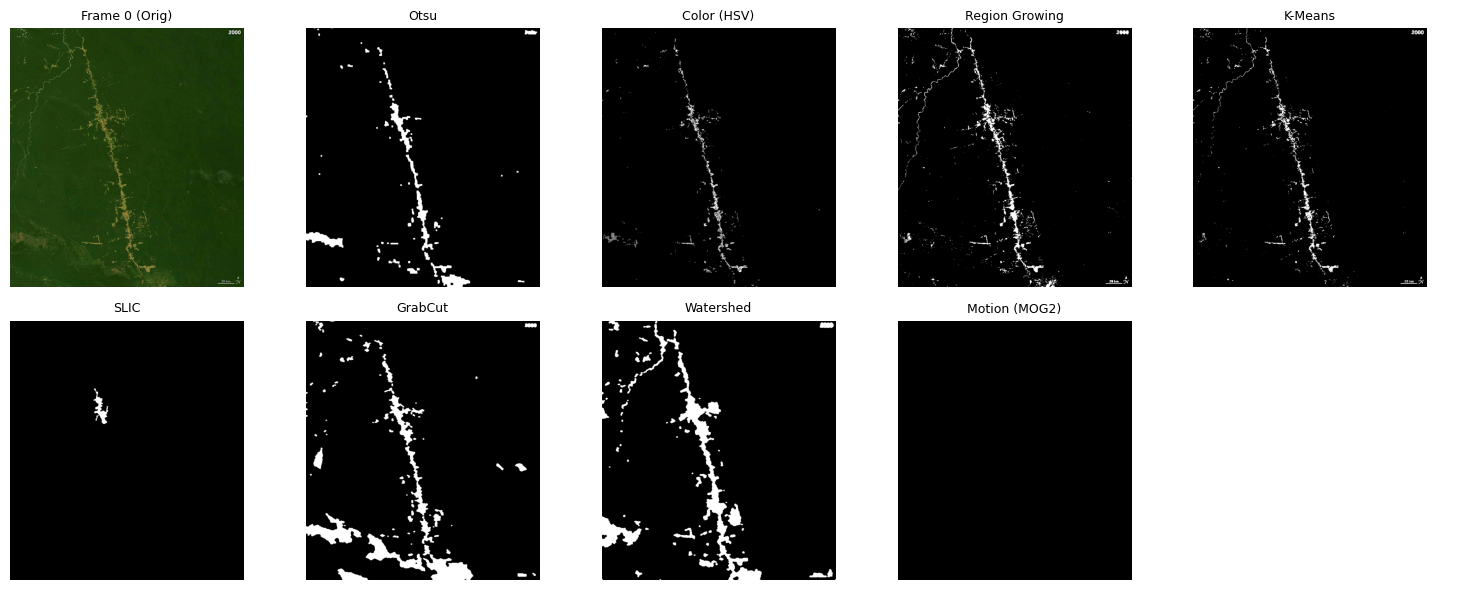

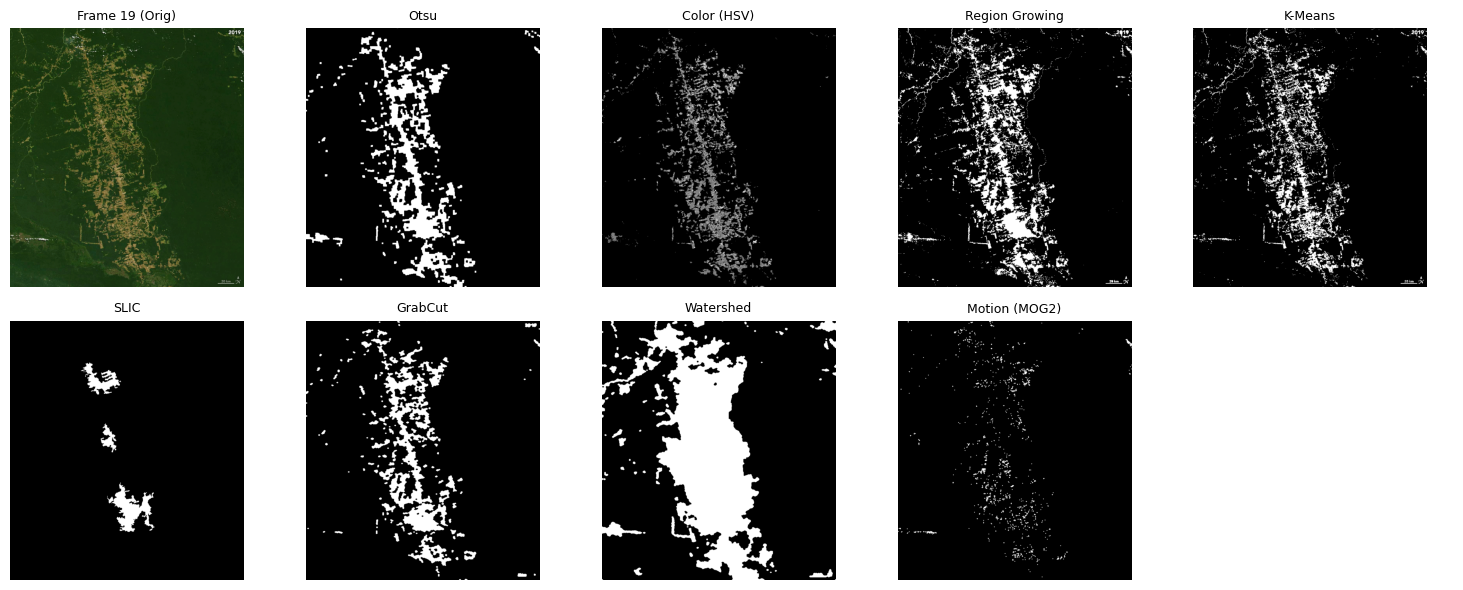

In [65]:
# --- Visualización de Resultados Refactorizada ---
methods = list(results.keys())

def show_img(ax, img_path, title, mask_path=None):
    if mask_path and os.path.exists(mask_path):
        img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if img is None: img = np.zeros((100,100), dtype=np.uint8)
    elif img_path:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img = np.zeros((100,100,3), dtype=np.uint8)
    
    ax.imshow(img, cmap='gray' if mask_path else None)
    ax.set_title(title, fontsize=9)
    ax.axis('off')

for frame_idx in [0, len(image_files) - 1]:
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes_flat = axes.flatten()
    
    # Frame original en la primera posición
    show_img(axes_flat[0], image_files[frame_idx], f"Frame {frame_idx} (Orig)")
    
    # Segmentaciones (Máximo 8 métodos para llenar las 9 posiciones restantes)
    for i, method in enumerate(methods[:8]):
        mask_fn = f"out/mask_{method.replace(' ', '_').replace('(', '').replace(')', '')}_{frame_idx}.png"
        show_img(axes_flat[i+1], None, method, mask_path=mask_fn)
    
    # Ocultar el subplot #10 (índice 9)
    axes_flat[-1].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'out/segmented_frames_{frame_idx}.png')
    plt.show()

## 5. Visualización de Resultados

In [66]:
for method_name, areas in results.items():
    
    results[method_name] = gaussian_filter1d(results[method_name], sigma=1).tolist()

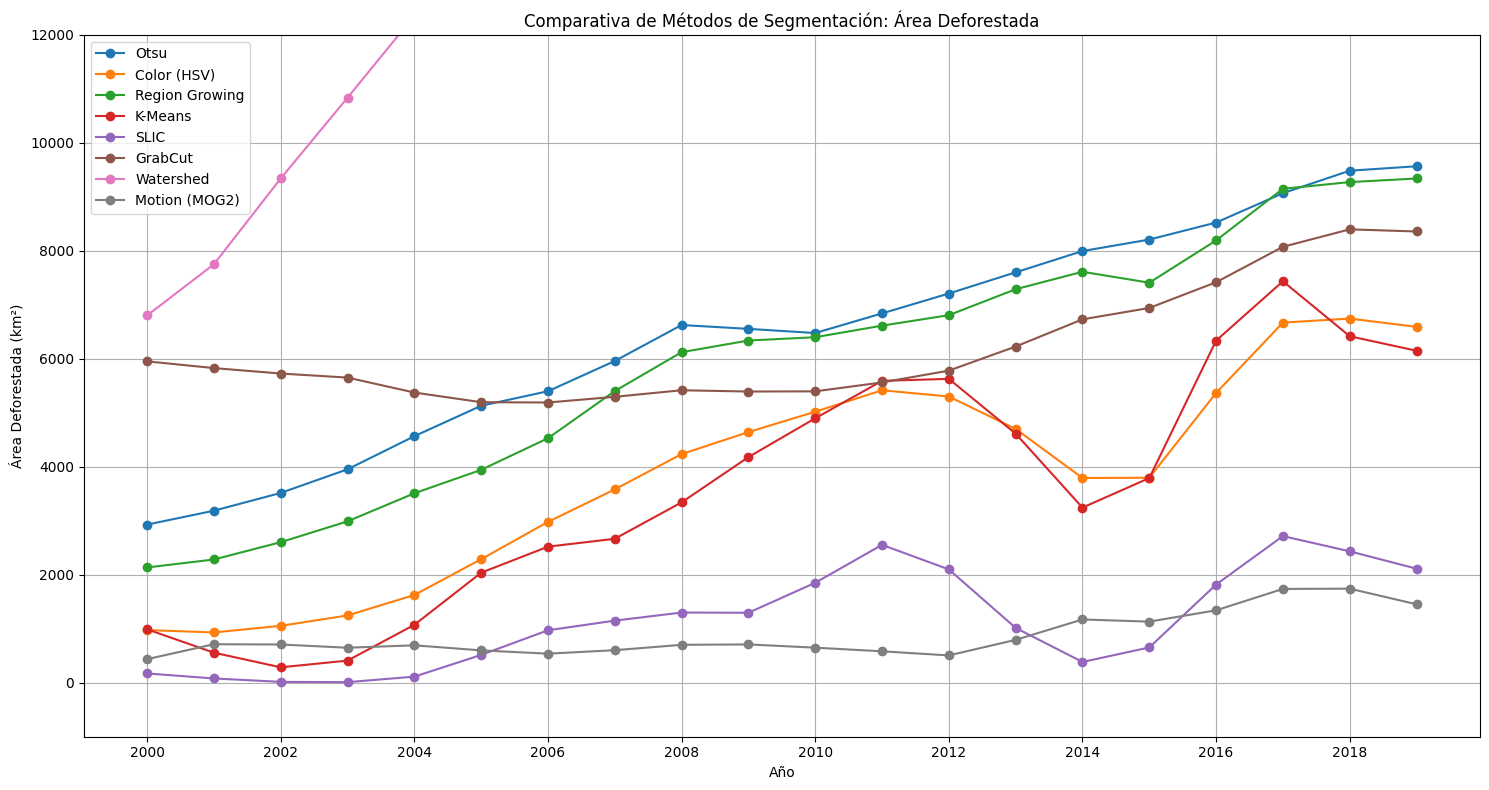

In [67]:
plt.figure(figsize=(15, 8))

# Graficar todos los resultados
for method_name, areas in results.items():

    if len(areas) == len(years):
        plt.plot(years, areas, marker='o', label=method_name)

plt.title('Comparativa de Métodos de Segmentación: Área Deforestada')
plt.xlabel('Año')
plt.ylabel('Área Deforestada (km²)')
plt.grid(True)
plt.xticks(np.arange(min(years), max(years) + 1, 2))
plt.legend()
plt.ylim(-1000,12000)
plt.tight_layout()
plt.savefig('out/area_deforestada_comparativo.png')
plt.show()